# Project: ML - Logistic Regression, Binary and MultiClass Classification (University Admissions and Car Origins)

<br>

## Questions to address:
- From the gpa scores predict if students were admited or not to University
- From data on the cylinders and yer built predict the orgin of cars (US, Europe or Asia)

<br>

## Tools:
- Models:
  - Logistic Regression
  - Logistic Regression, one-versus-all Method 
- Error Metric: ROC_AUC, Accuracy, TPR, TNR, MCC

<br>

### load defaults

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

print("Defaults Loaded")

Defaults Loaded


<br>

## Logistic Regression

- Logistic Regression outputs a probability value (that a given row should be labeled 1). In binary classification we can set a threshold and assign 1 to probability values above and 0 below. treshold = 0.5 in LogisticRegression by default

<br>

## Dataset: gpa, gre and whether or not students were admited to University

In [5]:
admissions = pd.read_csv('./data/admissions.csv')
display(admissions[:3])

,admit,gpa,gre
0,0,3.177277,594.102992
1,0,3.412655,631.528607
2,0,2.728097,553.714399


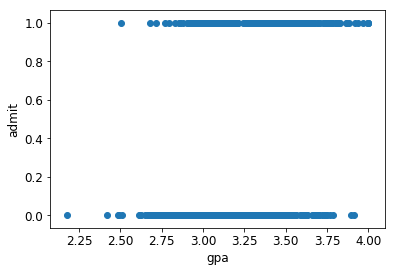

In [6]:
plt.scatter(admissions['gpa'],admissions['admit'])
plt.xlabel('gpa'), plt.ylabel('admit')
plt.show()

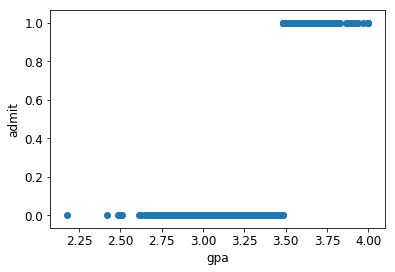

In [7]:
logistic_model = LogisticRegression(solver='lbfgs')
logistic_model.fit(admissions[["gpa"]], admissions["admit"])
pred_probs = logistic_model.predict_proba(admissions[["gpa"]])
admissions['predicted_label'] = logistic_model.predict(admissions[["gpa"]])

plt.scatter(admissions[["gpa"]], admissions['predicted_label'])
plt.xlabel('gpa'), plt.ylabel('admit')
plt.show()

suggests a liner relation, since logistic regression is used to capture a linear reltionship

<br>

### Error Metric: ROC_AUC

In [18]:
admissions = admissions.rename(columns={'admit': 'actual_label'})
roc_auc = roc_auc_score(admissions['actual_label'], admissions['predicted_label'])
print(f"Accuracy = {roc_auc:0.3f}")

Accuracy = 0.622


<br>

### Error Metric: Accuracy

In [19]:
matches = admissions['actual_label']==admissions['predicted_label']
correct_predictions = admissions[matches]

accuracy = len(correct_predictions)/len(admissions)
print("Accuracy = {:0.3f}".format(accuracy))

Accuracy = 0.685


<br>

### Error Metric: Sensitivity (True positice rate): $TPR = \frac{True\,Positives}{True\,Positives+False\,Negatives}$

In [15]:
true_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 1)
true_positives = len(admissions[true_positive_filter])

false_negatives_filter = (admissions["predicted_label"] == 0) & (admissions["actual_label"] == 1)
false_negatives = len(admissions[false_negatives_filter])

sensitivity = true_positives/(true_positives+false_negatives)
print("Sensitivity = {:0.3f}".format(sensitivity))

Sensitivity = 0.365


<br>

### Error Metric: Specificity (True Negative rate): $TNR = \frac{True\,Negatives}{False\,Positives+True\,Negatives}$

In [16]:
true_negative_filter = (admissions["predicted_label"] == 0) & (admissions["actual_label"] == 0)
true_negatives = len(admissions[true_negative_filter])

false_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 0)
false_positives = len(admissions[false_positive_filter])

specificity = true_negatives/(true_negatives+false_positives)
print("Specificity = {:0.3f}".format(specificity))

Specificity = 0.880


<br>

## One-versus-all Method
- Multiclass Classification

<br>

## Dataset: car properties and continent of origin

In [11]:
cars = pd.read_csv("./data/auto.csv")

#find unique values
unique_regions = cars['origin'].unique()
print(cars['origin'].value_counts())

1    245
3     79
2     68
Name: origin, dtype: int64


dummy coding

In [12]:
#categoric columns: cylinders, year, origin

#set prefix
dummy_cylinders = pd.get_dummies(cars["cylinders"], prefix="cyl")
cars = pd.concat([cars, dummy_cylinders], axis=1)

dummy_years = pd.get_dummies(cars['year'], prefix='year')
cars = pd.concat([cars, dummy_years], axis = 1)
cars.drop(['cylinders','year'], axis=1, inplace=True)

display(cars.iloc[:3,:15])

,mpg,displacement,horsepower,weight,acceleration,origin,cyl_3,cyl_4,cyl_5,cyl_6,cyl_8,year_70,year_71,year_72,year_73
0,18.0,307.0,130.0,3504.0,12.0,1,0,0,0,0,1,1,0,0,0
1,15.0,350.0,165.0,3693.0,11.5,1,0,0,0,0,1,1,0,0,0
2,18.0,318.0,150.0,3436.0,11.0,1,0,0,0,0,1,1,0,0,0


shuffle rows and split into train and test

In [13]:
np.random.seed(1)
shuffled_cars = cars.iloc[np.random.permutation(len(cars))]

train = shuffled_cars[0: int(0.7*len(shuffled_cars))]
test = shuffled_cars[int(0.7*len(shuffled_cars)):]

print("done")

done


**One versus all method:** choose one category as the positive case and group all others in the False case
- convert the problem into n binary classification problems
- train 3 models: 
  - cars made in America = 1, Europe and Asia = 0
  - cars made in Europe = 1, America and Asia = 0
  - cars made in Asia = 1, America and Europe = 0

then, for each observations choose the model the label (prediction) with highest probability

In [14]:
unique_origins = cars["origin"].unique()
unique_origins.sort()

models = {}

#train model just with year and cylinder dummy columns
cols = train.columns
cols_to_keep = (cols.str.contains('cyl') | cols.str.contains('year'))

testing_probs = pd.DataFrame(columns=unique_origins)

#train on train set
X = train[cols[cols_to_keep]]
for element in unique_origins:
    #select only rows with current label
    y = train['origin'] == element
    models[element] = LogisticRegression(solver='lbfgs')
    models[element].fit(X, y)

print("models fitted")

models fitted


In [15]:
#predict
y = test[cols[cols_to_keep]]    
for element in unique_origins:
    testing_probs[element]=models[element].predict_proba(y)[:,1]
    
display(testing_probs[:5])

,1,2,3
0,0.958401,0.035453,0.018950
1,0.979050,0.013642,0.023675
2,0.277985,0.356383,0.351180
3,0.983759,0.013213,0.018183
4,0.340172,0.261673,0.377821


In [16]:
predicted_origins = testing_probs.idxmax(axis=1)
cars['predicted_label'] = predicted_origins
cars.dropna(axis=0, inplace=True, how='any')
cars['predicted_label'] = cars['predicted_label'].astype('int')
display(cars['predicted_label'].iloc[:5])

0    1
1    1
2    2
3    1
4    3
Name: predicted_label, dtype: int64

<br>

### Error Metric: Accuracy

In [42]:
cars = cars.rename(columns={'origin': 'actual_label'})
matches = cars['actual_label']==cars['predicted_label']
correct_predictions = cars[matches]

accuracy = len(correct_predictions)/len(admissions)
print("Accuracy = {:0.3f}".format(accuracy))

Accuracy = 0.090


<br>

### Error Metric: Sensitivity(True Positive Rate), $TPR = \frac{True\,Positives}{True\,Positives+False\,Negatives}$

In [56]:
true_positives = 0
for element in  cars["actual_label"].unique():
    my_filter = (cars["predicted_label"] == element) & (cars["actual_label"] == element)
    true_positives += len(cars[my_filter])
    
false_negatives = 0
for element in  cars["actual_label"].unique():
    my_filter = (cars["predicted_label"] != element) & (cars["actual_label"] == element)
    false_negatives += len(cars[my_filter])    
    
sensitivity = (true_positives)/(true_positives+false_negatives)
print("Sensitivity = {:0.3f}".format(sensitivity))

Sensitivity = 0.492


<br>

### Error Metric: Specificity (True Negative rate), $TNR = \frac{True\,Negatives}{False\,Positives+True\,Negatives}$

In [59]:
true_negatives = 0
for element in  cars["actual_label"].unique():
    my_filter = (cars["predicted_label"] != element) & (cars["actual_label"] != element)
    true_negatives += len(cars[my_filter])
    
false_positives = 0
for element in  cars["actual_label"].unique():
    my_filter = (cars["predicted_label"] == element) & (cars["actual_label"] != element)
    false_positives += len(cars[my_filter])  
    
specificity = true_negatives/(true_negatives+false_positives)
print("Specificity = {:0.3f}".format(specificity))

Specificity = 0.746


<br>

### Error Metric: Matthew's Correlation Coefficient, $MCC = \frac{TP.TN-FP.FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$

In [64]:
MCC = ((true_positives*true_negatives-false_positives*false_negatives)/
       np.sqrt((true_positives+false_positives)*(true_positives+false_negatives)*
        (true_negatives+false_positives)*(true_negatives+false_negatives)))
print("MCC = {:0.3f}".format(MCC))

MCC = 0.237
